# Text Mining Coursework 2
## Topic: WinterOlympics
Team members: 
Bushui Zhang (UID: 10407579), Yazhuo Cao (UID: 10329221), Yecheng Chu (UID: 10319044), Zhaoyu Zhang (UID:10348535), Zhengqian Jin (UID:10839527)
### 3 Questions: 
1) What were the most talked about topics for the Winter Olympics?

2) What is the dominant sentiment towards the Winter Olympics?

3) Which 2 countries have been mostly talked about during Winter Olympics?  Which one do people prefer?

## Instructions for GTAs:
1. We have a large amount of tweets as dataset (around 50k), so we comment out some cells that process data to save marking time.
2. If you want to run it yourself, just uncomment codes for running the whole pipeline from scratch. Based on your machine's performance,it may take from half an hour to 2 hours to run the whole notebook.
3. If you want to save time, just run the notebook directly as our codes submitted are intend to load a saved version from a pre-run.

## Libraries Used

### may need to download a few packages

In [1]:
!pip install spacy
!pip install tweepy==4.8.0
!pip install wordcloud
!pip install gensim
!pip install pyldavis
!pip install vaderSentiment
!pip install spacy-transformers
!pip install spacy-entity-linker
!python -m spacy download en_core_web_trf  ### 460 MB
!python -m spacy_entity_linker download "knowledge_base"
!pip install emoji

     |████████████████████████████████| 460.2 MB 24 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [2]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm
# ignore warnings for now
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


# Access Tokens

In [3]:
api_token = "jXMA8AEL8KW4QBQpJZw69Mh77"
api_token_secret = "uD6xTzrqVU26M0MS7lG9s81FRgHUu5gHzDBhPp9Nf3goFObe19"
access_token = "1324002361694654465-8LZDKWBXdb6ac1J30r6SsRrfJj5Fh1"
access_token_secret = "PQKX7cInfMhrGi9mL63PlABxhdQlzXEMY1URBzQMxxiOk"
bearer_token = "AAAAAAAAAAAAAAAAAAAAADBgaQEAAAAAdpWH1Wc%2BG32Sj%2FZzrKX4U3jhkCI%3D7yHS67VXIxTOj1Db5lJB1yg6AB9i1FWeS0owPW0ZjofBsJ5lGd"

tokens = {}
tokens['api_token'] = api_token
tokens['api_token_secret'] = api_token_secret
tokens['access_token'] = access_token
tokens['access_token_secret'] = access_token_secret
tokens['bearer_token'] = bearer_token

# Configuring Twitter API

In [4]:
auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

## Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [5]:
# tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])

## Convert urls to tweets

In [6]:
# # Extract the tweet id
# tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]

# # Store tweet id in another column
# tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
# ids = tweet_urls['tweet_ids'].tolist()

# """
# convert twitter urls to tweets.
#  input: a list of ids, max 100 items
#  output: a list of tweets
# """
# def url2tweet(IDs):
#     # all_status = api.statuses_lookup(IDs)
#     all_status = api.lookup_statuses(IDs)
#     tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
#     return tweets_list

# """
# convert twitter url to tweets.
# use 100 as the base number for each section, as each request submitted to api.statuses_lookup is 100 items max.
#  input: a list of ids
#  output: a list of tweets
# """
# def get_all_tweets(IDs):
#     num_sections = (len(IDs) - 1) // 100 + 1
#     first_section = ids[:100]
#     data = url2tweet(first_section)
#     for i in tqdm(range(1, num_sections)):
#         current_ids = ids[i*100:(i+1)*100]
#         current_tweet_list = url2tweet(current_ids)
#         data = np.concatenate([data, current_tweet_list])
#     return data

# data = get_all_tweets(ids)

## Save the converted tweets to a csv file.

In [7]:
# tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
# tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
# tweets_df.head(len(tweets_df))

# Data Cleaning

In [8]:
"""
removes the emojis from a string.
input: a string contains emoji
output: a string without emoji
"""
def remove_emoji(string):
    string = emoji.get_emoji_regexp().sub(u'', string)
    return string

"""
removes/change unexpected string segments from tweets.
Right now contains 5 types:
1.hyperlinks
2.punctuation
3.line breaks
4.uppercase letters to lower
5.emoji
"""
def data_cleaning(data):
    # Remove hyperlinks
    data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

    # Remove punctuation
    data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

    # Remove unnecessary line breaks
    data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

    # Convert the titles to lowercase
    data.text = data.text.map(lambda x: x.lower())

    # Remove emojis
    data.text = data.text.map(lambda x: remove_emoji(x))

### Store the cleaned data

In [9]:
# Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

# do data cleaning
data_cleaning(tweets_df)

# store the processed tweets to csv
tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 1: What were people mostly talked about for the Winter Olympics?

## Exploration using a word cloud

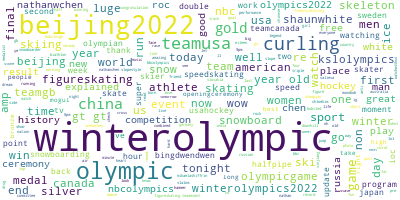

In [10]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets_all = list(set(list(tweets_df['text'].values)))
unique_tweets_all = [t for t in unique_tweets_all if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets_all)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [11]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['re', 'edu', 'th',  'amp', 'winterolympic', 'olympic', 'winterolympics', 'olympics', 
                   'beijing','winterparalympic', 'beijing2022', 'winter'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

## Get the Mostly Talked Topics

In [12]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 3

# build an LDA model
np.random.seed(0)
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.017*"nbcolympics" + 0.014*"teamusa" + 0.012*"nbc" + 0.012*"watchwithus" + '
  '0.012*"usa" + 0.011*"watch" + 0.011*"team" + 0.011*"figureskating" + '
  '0.010*"curling" + 0.010*"tonight"'),
 (1,
  '0.018*"opening" + 0.013*"ceremony" + 0.012*"first" + 0.010*"team" + '
  '0.010*"teamusa" + 0.009*"gold" + 0.009*"curling" + 0.009*"china" + '
  '0.008*"games" + 0.008*"watch"'),
 (2,
  '0.017*"watching" + 0.013*"curling" + 0.011*"china" + 0.009*"skating" + '
  '0.009*"time" + 0.008*"like" + 0.008*"figure" + 0.007*"athletes" + '
  '0.007*"sport" + 0.006*"ceremony"')]


### Visualise the topics

In [13]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.102952  0.127093       1        1  35.026144
1     -0.064583 -0.148101       2        1  34.202969
0      0.167534  0.021008       3        1  30.770887, topic_info=               Term         Freq        Total Category  logprob  loglift
323     nbcolympics  2200.000000  2200.000000  Default  30.0000  30.0000
241     watchwithus  1502.000000  1502.000000  Default  29.0000  29.0000
239             nbc  1531.000000  1531.000000  Default  28.0000  28.0000
3627        opening  3541.000000  3541.000000  Default  27.0000  27.0000
280   figureskating  1482.000000  1482.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
153             one   495.846742  1651.743345   Topic3  -5.5587  -0.0247
103        watching   509.413427  3374.155543   Topic3  -5.5317  -0.7120
40            women   458.391412  1286.181768   Topic3  -5.6373   0.1469
60             gold   449.670306  1834.335931   Topic3  -5.6565  -0.2273
106             get   435.361643  1385.826063   Topic3  -5.6888   0.0207

[266 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
857       3  0.995546          alexa
750       2  0.014814  alexa_knierim
750       3  0.992519  alexa_knierim
651       1  0.025462         alpine
651       2  0.952995         alpine
...     ...       ...            ...
69        3  0.107631          years
6971      1  0.012268         yuzuru
6971      3  0.993675         yuzuru
2525      2  0.996144        zealand
848       2  0.997361            zoi

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

## Hence, from the visualisation above we can conclude, people were mostly talked about these topics for the Winter Olympics:
1) Watching events at the winter Olympics.

2) The opening ceremony of the Winter Olympics.

3) The news about team USA by NBC Olympic news chanel.

# Task 2: What is the dominant sentiment towards the Winter Olympics?

## Sentiment Analysis (SA)

In [14]:
"""
get the sentiment analysis for a sepceifed sentiment key in tweets.
input: sentiment_key, if not given, all tweets will be researched.
output: positive, negative, neutral and compound scores for the sentiment analysis.
"""
dates = np.arange(4, 20) # winter olympics held from 2022.2.4 to 2022.2.20
def sentiment_analysis(sentiment_key=None):
    # variables to store sentiment data
    all_pos = 0 # positive
    all_neg = 0 # negative
    all_neu = 0 # neutral
    all_compounds = [] # compound

    # get sentiment data for each date
    for date in dates:
        compound = []

        if date >= 10:
            cur_date = '2022-02-%s'
        else:
            cur_date = '2022-02-0%s'
        cur_date = cur_date%date
        
        tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
        
        if sentiment_key is not None:
            tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(sentiment_key)]

        # Removing duplicate tweets
        unique_tweets = list(set(list(tweets_df_copy['text'].values)))
        unique_tweets = [t for t in unique_tweets if t]
        
        analyzer = SentimentIntensityAnalyzer()

        # get data for each text
        for tweet_text in unique_tweets:
            vs = analyzer.polarity_scores(tweet_text)
            compound_score = vs['compound']
            compound.append(compound_score)
            if compound_score >= 0.05:
                all_pos += 1
            elif compound_score <= -0.05:
                all_neg += 1
            else:
                all_neu += 1

        # calculate compound score and store
        general_compound_score = sum(compound) / len(compound)
        all_compounds.append(general_compound_score)
    
    return all_pos, all_neg, all_neu, all_compounds

In [15]:
all_pos, all_neg, all_neu, all_compounds = sentiment_analysis()

## Visualise the result

### Line chart of compound score on each date

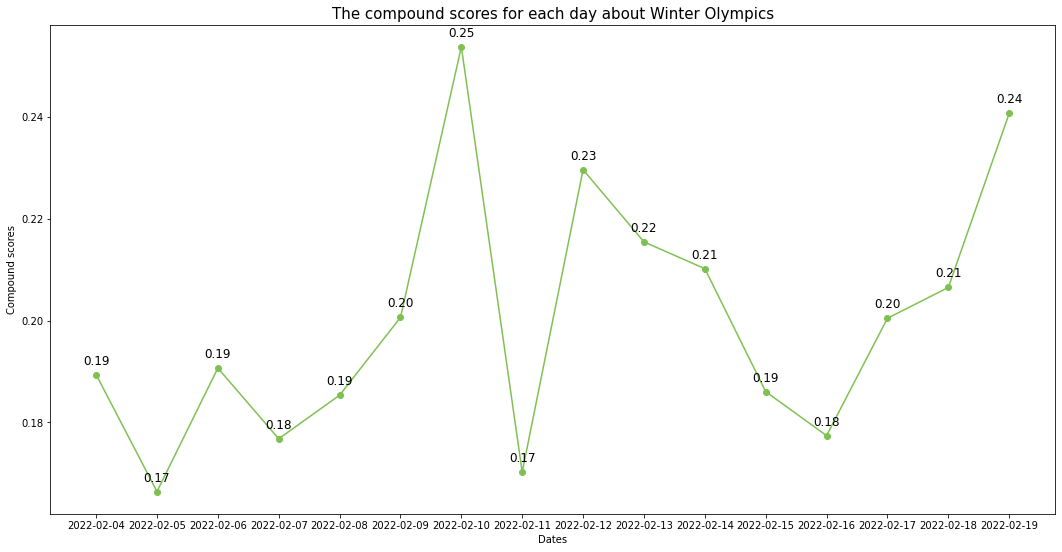

In [16]:
# get the plot x-labels
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)

# build the plot and show
plt.figure(figsize=(18,9))
plt.plot(all_compounds, 'o-', color = '#7EC151')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
plt.title("The compound scores for each day about Winter Olympics", fontsize=15)
x = dates
y = np.array(all_compounds)
# show y coordinate on each point
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.0015, '%.2f'%_y, ha='center', va='bottom', size=12, c='black')
plt.show()

### Pie chart of Positive, Negative and Neutral Sentiments of Winter Olympics

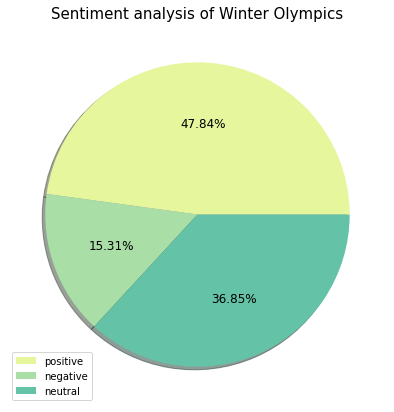

In [17]:
plt.figure(figsize=(7,7))
senti_data = [all_pos, all_neg, all_neu]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
plt.title('Sentiment analysis of Winter Olympics', fontsize=15)
plt.legend(labels)
plt.show()

# Task 3: Which 2 countries have been mostly talked about during Winter Olympics? Which one do people prefer?

## Named Entity Recognition (NER)

### Perform NER and save the result as a dictionary

❗Note: Uncomment the code to run NER and save the dictionary. It may take about *__more than one hour__* to run using Google Colab due the the huge amount of unique tweets (around 50000 tweets) been collected.

In [18]:
# nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

# # dictionary to store the result
# countries = {}
# # configure stopwords
# stop_words = ['beijing2022', 'beijing']
# # tqdm progress bar to visualise the progress
# pbar = tqdm("progess(for loop)", total = len(unique_tweets_all))

# """
# for each tweet, get NER labels in them and filter all "GPE"s as "GPE" represents countries, cities and states
# use a dictionary to count the number of times each country occurring.
# """
# for tweet_text in unique_tweets_all:
#     doc = nlp(tweet_text)
#     pbar.update(1)
#     for ne in doc.ents:
#         if ne.label_ == 'GPE':
#             tweet = tweet_text[ne.start_char:ne.end_char]
#             if tweet not in stop_words and tweet not in countries.keys():
#                 countries[tweet] = 1
#             elif tweet not in stop_words:
#                 countries[tweet] += 1

# with open('countries.pkl', 'wb') as f:
#     pickle.dump(countries, f)
#     f.close()

### Load a saved dictionary from a pre-run
### Save the dictionary (or load a saved version from a pre-run)

In [19]:
# Load a dictionary file called countries.pkl
with open('countries.pkl', 'rb') as f:
    countries = pickle.load(f)
    f.close()

### Visualise top 5 countries that are mostly mentioned

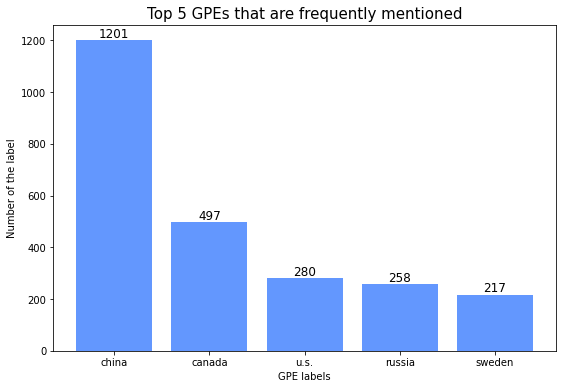

In [20]:
# sort the dictionary by descending orders of occurring times of each country
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}

# labels for first 5 countries
names = list(countries.keys())[0:5]
values = list(countries.values())[0:5]

# build the plot
plt.figure(figsize=(9,6))
plt.ylabel('Number of the label')
plt.xlabel('GPE labels')
plt.title('Top 5 GPEs that are frequently mentioned', fontsize=15)
plt.bar(range(5), values, tick_label=names, color = '#6397FE')
for _x, _y in zip(np.arange(5), values):
    plt.text(_x, _y, _y, ha='center', va='bottom', size=12, c='black')
plt.show()

In [21]:
mostly_talked_country = list(countries.keys())[0]
second_talked_country = list(countries.keys())[1]
print("As the bar chart shows, the 2 mostly talked countries are " + mostly_talked_country + " and " + second_talked_country)

As the bar chart shows, the 2 mostly talked countries are china and canada


## Sentiment Analysis (SA)

### get compound score for mostly talked country

In [22]:
all_pos_m, all_neg_m, all_neu_m, all_compounds_m = sentiment_analysis(sentiment_key=mostly_talked_country)

### get compound score for secondly talked country

In [23]:
all_pos_s, all_neg_s, all_neu_s, all_compounds_s = sentiment_analysis(sentiment_key=second_talked_country)

## Visualise the result

### Line chart of compound score for the top 2 most frequent mentioned countries on each date

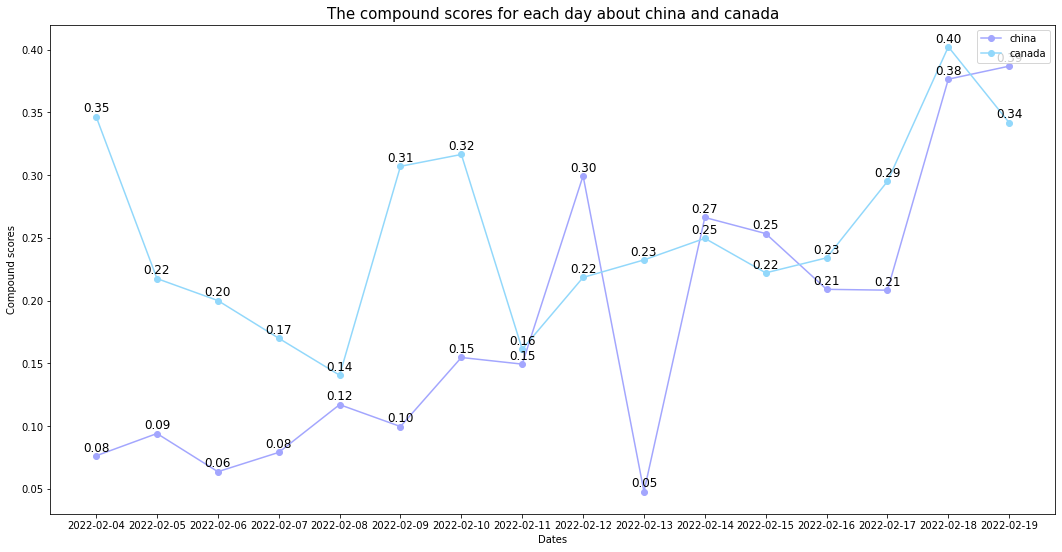

In [24]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds_m, 'o-', color = '#A3A6FE', label = mostly_talked_country)
plt.plot(all_compounds_s, 'o-', color = '#92D8FB', label = second_talked_country)
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
title_plt = "The compound scores for each day about " + mostly_talked_country + " and " + second_talked_country
plt.legend()
plt.title(title_plt, fontsize=15)
x = dates
y1 = np.array(all_compounds_m)
y2 = np.array(all_compounds_s)
for _x, _y1, _y2 in zip(x, y1, y2):
    plt.text(_x-4, _y1+0.0015, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x-4, _y2+0.0015, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.show()

### Bar chart of sentiment analysis for the top 2 most frequent mentioned countries in terms of percentage

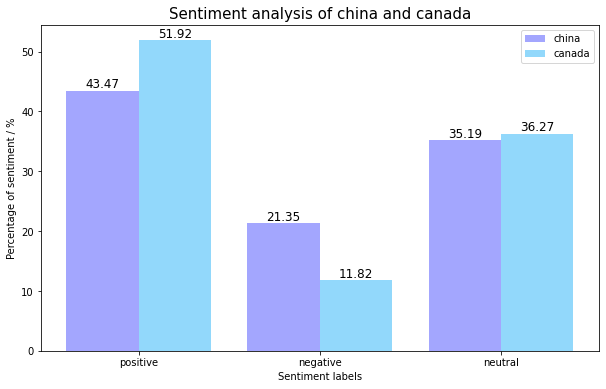

In [25]:
"""
data calculations on mostly and secondly frequent countries,
positive, negative and neutral data are counted.
"""
all_m = all_pos_m + all_neg_m + all_neu_m
all_s = all_pos_s + all_neg_s + all_neu_s
all_pos_pm = (all_pos_m / all_m) * 100
all_neg_pm = (all_neg_m / all_m) * 100
all_neu_pm = (all_neu_m / all_m) * 100
all_pos_ps = (all_pos_s / all_s) * 100
all_neg_ps = (all_neg_s / all_s) * 100
all_neu_ps = (all_neu_s / all_s) * 100
all_pm = [all_pos_pm, all_neg_pm, all_neu_pm]
all_ps = [all_pos_ps, all_neg_ps, all_neu_ps]
names = ['positive', 'negative', 'neutral']

# plot the figure
plt.figure(figsize=(10,6))
plt.ylabel('Percentage of sentiment / %')
plt.xlabel('Sentiment labels')
title_plt = "Sentiment analysis of " + mostly_talked_country + " and " + second_talked_country
plt.title(title_plt, fontsize=15)

X_axis = np.arange(3)
plt.xticks(X_axis, names)
plt.bar(X_axis - 0.2, all_pm,0.4,label=mostly_talked_country, color = '#A3A6FE')
plt.bar(X_axis + 0.2, all_ps,0.4,label=second_talked_country, color = '#92D8FB')
for _x, _y1, _y2 in zip(np.arange(3), all_pm, all_ps):
    plt.text(_x-0.2, _y1, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x+0.2, _y2, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.legend()